# Noncovalent interactions and NMR observables
## Some ideas for the NONCOV Toolbox in Python

### Ettore Bartalucci, Progress Report 17.09.2024

## Introduction

* Noncovalent interactions can be experimentally detected from NMR parameters (e.g. changes in $\sigma_{iso}$)

* 

here test

However, some of the questions that are yet to be answered are:

* How sensitive are individual nuclei to NCIs?
* How is the response of each nucleus to different NCI? e.g. are there preferential ones?
* Whats the geometric response of NMR observables undergoing NCIs?
* Is it possible to separate the contributions of each NCIs to a selected observable of interest?
* BONUS: Can we machine learn these trends?

## Structure

Two fundamental concepts:

<p float="left">
  <img src="oreilymeme1.png" width="350" />
  <img src="oreilymeme2.png" width="350" /> 
</p>


```mermaid
graph TD
nci["Choose NCI
    fragments"] --> dft("Relax structures
                        @DFT")
    
    dft -->|HPC@MPI| crest["in-silico 
                            CREST/CENSO l.e.c."]
    dft -->|StructureModifier| displace[Displace fragments]
    dft -->|StructureModifier| rotate[Rotate Fragments]

    crest --> nmr["Compute 
                    NMR parameters"]
    displace --> nmr["Compute 
                    NMR parameters"]
    rotate --> nmr["Compute 
                    NMR parameters"]

    nmr -->postproc["General
                    postprocessing"]
    postproc --> sigma[Shielding Tensor]
    postproc --> j[j_iso]
    postproc --> meyer[Meyer B.O.]
    postproc --> else[Anything else?]

    sigma --> ml[Input for ML dataframe]
    j --> ml[Input for ML dataframe]
    meyer --> ml[Input for ML dataframe]
    else --> ml[Input for ML dataframe]

    sigma --> view[Plots]
    j --> view[Plots]
    meyer --> view[Plots]
    else --> view[Plots]

    ml --> predictions["Predict NCI
                        contribution %
                        to NMR parameters"]
```

A possible Dataset for Machine learning could look like this:

In [ ]:
columns = ['Molecule', 
                    'Atom', 
                    'x_coord', 
                    'y_coord', 
                    'z_coord', 
                    'sigma_11', 
                    'sigma_22', 
                    'sigma_33', 
                    'dia_sigma_11', 
                    'dia_sigma_22', 
                    'dia_sigma_33', 
                    'para_sigma_11', 
                    'para_sigma_22', 
                    'para_sigma_33', 
                    'sigma_iso', 
                    'nmr_functional', 
                    'nmr_basis_set', 
                    ]
rows = ['benzene_h2o_1', '0H', 0.000, 0.000, 0.000, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 'r2-SCAN 3c', 'def2-mTZVPP']

df = pd.DataFrame([rows], columns=columns)
df


: 

In [ ]:
columns = ['Molecule', 
                    'Atom_1', 
                    'Atom_2',
                    'x_coord1', 
                    'y_coord1', 
                    'z_coord1', 
                    'x_coord2', 
                    'y_coord2', 
                    'z_coord2',
                    'J_iso',
                    'J_FC_11',
                    'J_FC_22',
                    'J_FC_33',
                    'J_DSO_11',
                    'J_DSO_22',
                    'J_DSO_33',
                    'J_PSO_11',
                    'J_PSO_22',
                    'J_PSO_33',
                    'J_SD_11',
                    'J_SD_22',
                    'J_SD_33',
                    'Mayer_BO' 
                    ]
rows = ['benzene_h2o_1', '0H', '1C', 0.000, 0.000, 0.000, 1.000, 1.000, 1.000, 125.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

df = pd.DataFrame([rows], columns=columns)
df


: 

## Preconfig NONCOVToolbox Library

In [1]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [ ]:
# Get configuration file 
configdir = os.getcwd()
configdir = os.path.abspath(os.path.join('..', 'config'))

configs = os.path.join(configdir, 'configuration.yml')
print(f'Change with care, configuration file is in:', configs)

print('And looks like this...\n')
with open(configs,'r') as f:
    config_file = f.read()
    print(config_file)

In [2]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

mol_dir = os.path.join(scratch_dir, 'test_structs/benzene_H2O.xyz')
print(f'Current molecule directory is: {mol_dir}')
mol_dir = OrcaAnalysis().convert_path(mol_dir)

Current work directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\results
Current scratch directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch
Current molecule directory is: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch\test_structs/benzene_H2O.xyz
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz


## Module: StructureModifier

Here some text

In [3]:
# Relative paths
start_structure = os.path.join(scratch_dir, 'StructureModifier/input_structures/KLaL_cation_pi_RCCE_opt_NICS.xyz')
centroid_out = os.path.join(scratch_dir, 'StructureModifier/centroid_output/centroid_file.xyz')
input_file = os.path.join(scratch_dir, 'StructureModifier/input_file/input_file.txt')

In [ ]:
with open(input_file, 'r') as file:
    input_content = file.read()
    print(input_content)

In [4]:
# Read xyz file: this should be either a fully optimized geometry or one with relaxed H
coordinates, atom_identities = StructureModifier().read_atomic_coord(start_structure)
#print(f'Starting coordinates: {coordinates}')
#print(f'Atom identities: {atom_identities}')

In [5]:
# Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics soft
coords1, coords2 = StructureModifier().assign_molecule_fragments(coordinates, input_file)

# Concatenate coordinates for k-means clustering
all_coords = np.concatenate((coords1, coords2), axis=0)
# print(f'All coords: {all_coords}')

# Count how many fragments you have defined in the input file, important for accurate K-means clustering
n_fragments = StructureModifier().count_fragments(input_file)
#print(f"Number of '$fragment': {n_fragments}")

In [6]:
# Perform k-means clustering to compute centroids
kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
kmeans.fit(all_coords)
centroids = kmeans.cluster_centers_

# Compute centroids for each fragment
fragment_centroids = StructureModifier().calculate_centroids([coords1, coords2])

# Write centroid coordinates to file
StructureModifier().write_centroids(centroid_out, fragment_centroids)
#print(f'Centroid coordinates: {fragment_centroids}')

In [7]:
# Calculate displacement direction (line connecting centroids)
displacement_direction = centroids[1] - centroids[0]
displacement_direction /= np.linalg.norm(displacement_direction)
#print(f'Displacement direction:{displacement_direction}')

In [8]:
# Read displacement step size from input file
displacement_step = None
with open(input_file, 'r') as f:
    lines = f.readlines()
    read_displacement = False
    for line in lines:
        if read_displacement:
            displacement_values = line.strip().split()
            if displacement_values:
                displacement_step = float(displacement_values[0])
                break
        elif line.strip() == "$displacement":
            read_displacement = True

if displacement_step is None:
    print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
print(f'Displacement step is: {displacement_step} Angstroem') # please doublecheck that it is the same value you defined in the input

Displacement step is: 0.1 Angstroem


In [9]:
# Displace the first fragment iteratively and save each structure
displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
#print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

# Initialize the coordinates for the fixed fragment (e.g., coords2)
coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
#print(f'Original coordinates fixed fragment:', coords_fixed)

all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

# Combine displaced coordinates with original ones
all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

In [12]:
# Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
diss_lim = 50 # change with the output value in agnstrom from func(dissociation_limit)

for i in range(1, diss_lim):  # Iterate 50 times (adjust the number as needed) put this as to be the dissociation limit of each DFT run

    displacement_vector = [] 

    # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
    displaced_fragment_coords = StructureModifier().displace_fragment(coords1, displacement_direction, displacement_step, i)
    #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

    combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
    all_combined_coords.append(combined_coords)

    # Update centroids for the displaced structure
    fragment_centroid = StructureModifier().calculate_centroids([displaced_fragment_coords])
    fragment_centroids.append(fragment_centroid[0])
    print(f'Updated centroids:', fragment_centroid)
    
    # Write displaced structure to file
    output_file = os.path.join(scratch_dir, f'StructureModifier/displaced_structures/displaced_structure_{i}.xyz')
    StructureModifier().write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

    all_displaced_fragment_coords.append(displaced_fragment_coords)

    # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
    centroid_to_displaced_distance = StructureModifier().compute_distance_from_centroid(displaced_fragment_coords, centroids)
    print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

    # Write distances to file - needed for DFT calculations outputs
    distance_output_file = os.path.join(scratch_dir, f'StructureModifier/distance_files/distances_structures_{i}.xyz')

    StructureModifier().write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)

Displacement vector: [ 0.01944485 -0.00300354  0.09804528]
<class 'numpy.ndarray'>
Updated centroids: [[ -0.66650485   0.78623354 -15.02193528]]
Distance between displaced coordinates and centroid is: [3.04691146]
Displacement vector: [ 0.03888969 -0.00600707  0.19609056]
<class 'numpy.ndarray'>
Updated centroids: [[ -0.68594969   0.78923707 -15.11998056]]
Distance between displaced coordinates and centroid is: [2.97737141]
Displacement vector: [ 0.05833454 -0.00901061  0.29413584]
<class 'numpy.ndarray'>
Updated centroids: [[ -0.70539454   0.79224061 -15.21802584]]
Distance between displaced coordinates and centroid is: [2.90960679]
Displacement vector: [ 0.07777939 -0.01201415  0.39218112]
<class 'numpy.ndarray'>
Updated centroids: [[ -0.72483939   0.79524415 -15.31607112]]
Distance between displaced coordinates and centroid is: [2.8437445]
Displacement vector: [ 0.09722423 -0.01501769  0.49022639]
<class 'numpy.ndarray'>
Updated centroids: [[ -0.74428423   0.79824769 -15.41411639]]


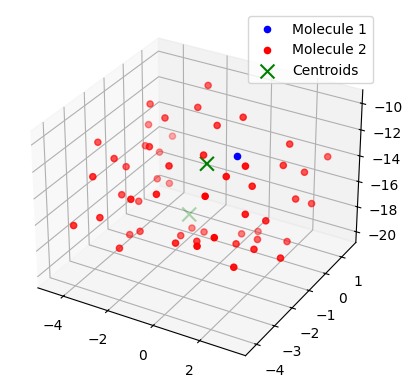

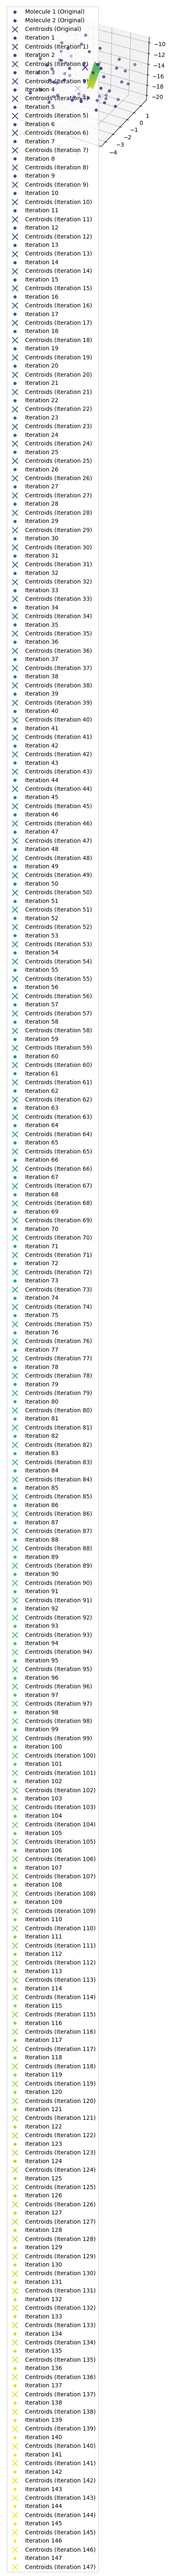

In [13]:
# Plot initial topology for molecular fragments and centroids
fig = StructureModifier().plot_starting_molecular_fragments(coords1, coords2, centroids)

# Generate colors for the plots based on displacement iteration
num_iterations = len(all_displaced_fragment_coords)
colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

# Plot displaced molecular fragments and centroids
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original fragments and centroids
ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

# Plot displaced fragments and centroids
for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
    color = colors[i]
    label = f'Iteration {i}'
    ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
    ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

ax.legend()
plt.show()

## Modules: OrcaAnalysis

here some description

In [ ]:
# Provide files you want to process as input 
# Example: "D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\tests\data\KLaL_cation_pi_RCCE_opt.mpi8.out"
orca_output = input("Enter the path to the ORCA file you want to work with: ")
orca_output = OrcaAnalysis().convert_path(orca_output)

In [ ]:
# Working with ORCA .out files

# Count how many sequential calculations have been done
n_jobs = OrcaAnalysis().count_jobs_number(orca_output)
print(f'Number of ORCA jobs in file: {n_jobs}\n')

# Compute size of the .out file and suggest Git LFS 
size_orca_output = os.path.getsize(orca_output)
size_orca_output = size_orca_output/1024
print(f'Size of ORCA file is: {size_orca_output} KB\n')

if n_jobs > 20:
    print(f'Careful, you are working with a possibly large output file of several GB\n')
    print(f'If using version controls consider setting up a .gitignore \n')

if size_orca_output > 1000:
    print(f"Careful, you are working with a '{size_orca_output}' KB large file..\n")
    print(f'Set up a .gitignore or Git LFS before pushing to Git\n')

# Extract level of theory
lot_out = OrcaAnalysis().extract_level_of_theory(orca_output)
print(f'Level of theory for the NMR calculations is: {lot_out}\n')

# Split orca output in several subfiles for ease of handling (takes a while)
if n_jobs > 2:
    print('Your output file will be now spilt into subfiles. \n')
    OrcaAnalysis().split_orca_output(scratch_dir, orca_output)

In [ ]:
# Define the empirical boundaries ([A]) for various noncovalent interactions
OrcaAnalysis().run_boundary_checks()

In [ ]:
# Initialize displacement steps in Angstrom - need to find a clever way to do this
displacement_steps_distance = [job * 0.25 for job in range(1,n_jobs+1)]

In [ ]:
bond_orders = OrcaAnalysis().extract_bond_orders(filename)

# Print the bond orders and their interacting nuclei
for nucleus, bonds in bond_orders.items():
    print(f"{nucleus}:")
    for interacting_nucleus, bond_order in bonds:
        print(f"  Bond with {interacting_nucleus}: {bond_order}")

In [ ]:
# --- Extract the CSA tensor components for each nucleus at each distance iteration --- #

# Initialize variables for shielding tensor components
S_dia = []
S_para = []
S_tot = []
nuclear_identities = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1): # split files = number of jobs
        
    blockPrint()
    # Path to the splitted outputs from the .out MPI8 file
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output', f'splitted_orca_job{job_number}.out'))
    
    # Extract CSA data
    shielding_dia, shielding_para, shielding_tot, nucleus_info = OrcaAnalysis().extract_tensor_data(orca_splitted_output)

    enablePrint()
    
    # Append shielding tensor matrices (non-diagonalized) - all nuclei for each job iteration
    S_dia.append(shielding_dia)
    S_para.append(shielding_para)
    S_tot.append(shielding_tot)
    nuclear_identities.append(nucleus_info)

# Transform into PAS 
# Iterate over each job's shielding tensors in S_tot
for job_index, shielding_dict in enumerate(S_tot):
    
    rows = []
    columns = ('Nucleus', '\u03C3_iso', '\u03C3_11', '\u03C3_22', '\u03C3_33', 'Symmetry')
   
    # Check if shielding_dict is a dictionary and contains items
    if isinstance(shielding_dict, dict):

        for nucleus_key, tensor in shielding_dict.items():
            
            shielding_tensor, s_iso, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions().diagonalize_tensor(tensor)
            
            sigma_11 = diagonal_mehring[0][0]
            sigma_22 = diagonal_mehring[1][1]
            sigma_33 = diagonal_mehring[2][2]
            data = (nucleus_key, s_iso, sigma_11, sigma_22, sigma_33, symmetry)
            
            # Collect the row data in a list
            rows.append(data)

    else:
        print(f"Error: Expected a dictionary but got {type(shielding_dict)}")

    # Convert rows to a DataFrame and concatenate
    df = pd.concat([pd.DataFrame([row], columns=columns) for row in rows], ignore_index=True)
    
        
    df_out = os.path.join(scratch_dir, f'OrcaAnalysis/dataframe_job{job_index}.csv'
    df.to_csv(df_out, index=False)
    print(f"Saved {df_out}")


In [ ]:
# Plot data from dataframes

csv_files = glob.glob('dataframe_job*.csv')  # Adjust the pattern if necessary

for job_index, file in enumerate(csv_files):
    
    df = pd.read_csv(file, header=None, names=['Nucleus', 's_iso', 'σ_11', 'σ_22', 'σ_33', 'Symmetry'])

    for _, row in df.iterrows():
        nucleus = row['Nucleus'].strip()
        s_iso = row['s_iso']
        sigma_11 = row['σ_11']
        sigma_22 = row['σ_22']
        sigma_33 = row['σ_33']

        if nucleus not in nucleus_data:
            nucleus_data[nucleus] = []
        
        # Append the s_iso value for this job_index
        nucleus_data[nucleus].append(s_iso)
        
for nucleus, s_iso_values in nucleus_data.items():
    plt.figure()
    plt.plot(range(len(s_iso_values)), s_iso_values, marker='o')
    plt.title(f's_iso values for {nucleus}')
    plt.xlabel('Job Index')
    plt.ylabel('s_iso')

    plt.show() 
    plt.clf()

## Modules: MolView

here some text

In [ ]:
# molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'
molecule = 'C:/Users/ettor/Desktop/NONCOV/scratch/test_structs/benzene_H2O.xyz'

MolView().plot_3d_molecule(molecule)

In [ ]:
# Plot euler angles and rotated tensor
tensor_pas = np.diag([1.0, 2.0, 3.0])  # Diagonal tensor in PAS
alpha, beta, gamma = 30, 45, 60  # Euler angles in degrees
MolView.plot_3D_tensors_and_axes(tensor_pas, alpha, beta, gamma)


## Modules: NMRFunctions

here some text

In [ ]:
# Tensor to Euler angles
mode = 'AZYZ'
order = 'Ascending'
alpha, beta, gamma, tensor_pas = NMRFunctions().tensor_to_euler(shielding_tensor, eigenvals, eigenvecs, symmetry, mode, order)

In [ ]:
# Generate equivalent sets of angles
NMRFunctions().EqEulerSet(alpha,beta,gamma)

## Modules: MolecularGraph

In [ ]:
fragment1 =(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
fragment2 = (13, 14, 15)

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(mol_dir)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
#mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)


threshold = 1.6

## Modules: DistanceScanner & RotationScanner

In [ ]:
# WORKING WITH RELATIVE PATHS 
current_dir = os.getcwd()
print(current_dir)

# LOGS AND ERRORS
error_log_file = 'error_log_file.txt' # to finish
log_file = 'log_file.txt' # to finish


# START TIMER: COMPUTE EFFECTIVE WALL TIME
start = timer() # this is not in [sec] i think

# SECTON: MAIN
def main():

    # Relative paths
    start_structure = os.path.join(current_dir, 'input_structures/KLaL_cation_pi_RCCE_opt_NICS.xyz')
    centroid_out = os.path.join(current_dir, 'centroid_output/centroid_file.xyz')
    input_file = os.path.join(current_dir, 'input_file/input_file.txt')

    # Read xyz file: this should be either a fully optimized geometry or one with relaxed H
    coordinates, atom_identities = read_atomic_coord(start_structure)
    print(f'Starting coordinates: {coordinates}')
    print(f'Atom identities: {atom_identities}')

    # Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics soft
    coords1, coords2 = assign_molecule_fragments(coordinates, input_file)

    # Concatenate coordinates for k-means clustering
    all_coords = np.concatenate((coords1, coords2), axis=0)
    # print(f'All coords: {all_coords}')

    # Count how many fragments you have defined in the input file, important for accurate K-means clustering
    n_fragments = count_fragments(input_file)
    print(f"Number of '$fragment' occurrences: {n_fragments}")

    # Perform k-means clustering to compute centroids
    kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
    kmeans.fit(all_coords)
    centroids = kmeans.cluster_centers_

    # Compute centroids for each fragment
    fragment_centroids = calculate_centroids([coords1, coords2])

    # Write centroid coordinates to file
    write_centroids(centroid_out, fragment_centroids)
    print(f'Centroid coordinates: {fragment_centroids}')

    # Calculate displacement direction (line connecting centroids)
    displacement_direction = centroids[1] - centroids[0]
    displacement_direction /= np.linalg.norm(displacement_direction)
    print(f'Displacement direction:{displacement_direction}')

    # Read displacement step size from input file
    displacement_step = None
    with open(input_file, 'r') as f:
        lines = f.readlines()
        read_displacement = False
        for line in lines:
            if read_displacement:
                displacement_values = line.strip().split()
                if displacement_values:
                    displacement_step = float(displacement_values[0])
                    break
            elif line.strip() == "$displacement":
                read_displacement = True

    if displacement_step is None:
        print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
        return
    print(f'Displacement step is: {displacement_step}') # please doublecheck that it is the same value you defined in the input

    # Displace the first fragment iteratively and save each structure
    displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
    print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

    # Initialize the coordinates for the fixed fragment (e.g., coords2)
    coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
    print(f'Original coordinates fixed fragment:', coords_fixed)

    all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

    # Combine displaced coordinates with original ones
    all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

    fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

    # Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
    diss_lim = 50 # change with the output value in agnstrom from func(dissociation_limit)

    for i in range(1, diss_lim):  # Iterate 50 times (adjust the number as needed) put this as to be the dissociation limit of each DFT run
        
        displacement_vector = [] 

        # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
        displaced_fragment_coords = displace_fragment(coords1, displacement_direction, displacement_step, i)
        #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

        combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
        all_combined_coords.append(combined_coords)

        # Update centroids for the displaced structure
        fragment_centroid = calculate_centroids([displaced_fragment_coords])
        fragment_centroids.append(fragment_centroid[0])
        print(f'Updated centroids:', fragment_centroid)

        # Write displaced structure to file
        output_file = Path(os.path.join(current_dir, f'displaced_structures/displaced_structure_{i}.xyz'))
        write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

        all_displaced_fragment_coords.append(displaced_fragment_coords)

        # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
        centroid_to_displaced_distance = compute_distance_from_centroid(displaced_fragment_coords, centroids)
        print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

        # Write distances to file - needed for DFT calculations outputs
        distance_output_file = Path(os.path.join(current_dir, f'distance_files/distances_structures_{i}.xyz'))
        write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)


    # Plot initial topology for molecular fragments and centroids
    fig = plot_starting_molecular_fragments(coords1, coords2, centroids)

    # Generate colors for the plots based on displacement iteration
    num_iterations = len(all_displaced_fragment_coords)
    colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

    # Plot displaced molecular fragments and centroids
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original fragments and centroids
    ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
    ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

    # Plot displaced fragments and centroids
    for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
        color = colors[i]
        label = f'Iteration {i}'
        ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
        ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

    ax.legend()
    plt.show()


    # END TIMER: STOP TIMER AND PRINT
    elapsed_time = timer() - start  # in seconds
    print(f'Elapsed time for the code to run is: {elapsed_time}')


if __name__ == '__main__':
    main()


## Modules: GenerateMLDataset

In [ ]:
dataset_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {dataset_dir}')
dataset_dir = OrcaAnalysis().convert_path(dataset_dir)

MachineLearning().make_empty_database(dataset_dir)

df = pd.read_csv(dataset_dir)
df

## Modules: AminoStat

In [ ]:
# # Example usage
# toolbox = NONCOVToolbox()
# amino_stats = toolbox.AminoStat()

# # Example usage
# current_dir = os.getcwd()

# protein_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spidersilks.txt')
# spaced_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spaced_spidersilks.txt')
# count_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_count.txt')
# plot_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_statistics.pdf')

# #amino_stats = AminoStat()

# amino_stats.space_prot_seq(protein_sequence, spaced_sequence)
# amino_stats.count_amino_acids(spaced_sequence, count_file)
# amino_stats.plot_amino_acid_statistics(count_file, plot_file)

# amino_stats.define_protein_domains()


## Here xtb, CENSO, CREST